In [ ]:
# Importing required libraries
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from scipy.stats import gaussian_kde
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [ ]:
# Load the data
data = pd.read_excel("PSP_Jan_Feb_2019.xlsx")
warnings.filterwarnings("ignore")


In [ ]:
# Drop unnecessary columns
data = data.drop('Unnamed: 0', axis=1)
# remove the data with missing values
data = data.dropna()

### **Preliminary Data Exploration**

In [ ]:
print("\nData set:")
print(f"Number of Rows: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")



Data set:
Number of Rows: 50410
Number of Columns: 7


In [ ]:
# Display the first few rows of the dataset
print("\nData:")
data.head()


Data:


,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [ ]:
# Check for Duplicate Rows
duplicates = data[data.duplicated()]
print(f"\nNumber of Duplicate Rows: {duplicates.shape[0]}")


Number of Duplicate Rows: 81


In [ ]:
# remove the Duplicate data

print("\nData after removing the duplicates:")
print(f"Number of Rows befor removing the duplicates: {data.shape[0]}")
data = data.drop_duplicates()
print(f"Number of Rows after removing the duplicates: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")


Data after removing the duplicates:
Number of Rows befor removing the duplicates: 50410
Number of Rows after removing the duplicates: 50329
Number of Columns: 7


In [ ]:
# Data Understanding
data_info = data.info()
data_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50329 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50329 non-null  datetime64[ns]
 1   country     50329 non-null  object        
 2   amount      50329 non-null  int64         
 3   success     50329 non-null  int64         
 4   PSP         50329 non-null  object        
 5   3D_secured  50329 non-null  int64         
 6   card        50329 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


### **Data Quality Measurements**



In [ ]:
# To check Null Values
data.isnull().sum()

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [ ]:
# To check Unique Values
data.nunique()

tmsp          50121
country           3
amount          517
success           2
PSP               4
3D_secured        2
card              3
dtype: int64

In [ ]:
# Summary Statistics
data.describe()

,amount,success,3D_secured
count,50329.000000,50329.000000,50329.000000
mean,202.379622,0.203223,0.238312
std,96.255629,0.402401,0.426055
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


### **Exploratory data analysis**



PSP Success Rates:
             success
PSP                 
Goldcard    0.406172
Moneycard   0.218833
Simplecard  0.158212
UK_Card     0.194861
	

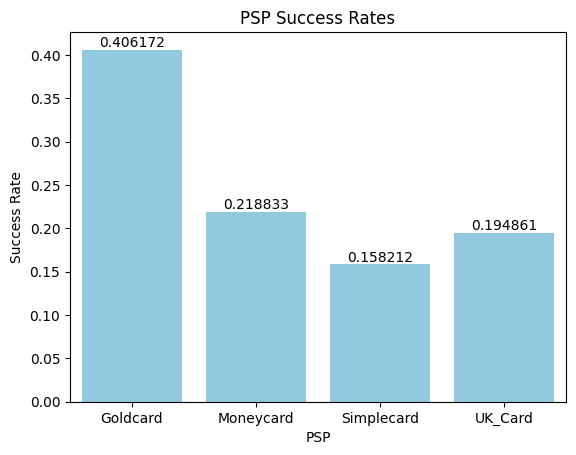

In [ ]:
# List of PSPs and service fees
psp_fees = pd.DataFrame({
    'name': ['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard'],
    'Fee_on_successful_transactions': [5, 10, 3, 1],
    'Fee_on_failed_transactions': [2, 5, 1, 0.5]
})
# Merge data with PSP fees
data = pd.merge(data, psp_fees, how='left', left_on='PSP', right_on='name')
# Calculate success rates for each category
psp_success_rates = data.groupby(['PSP'])[['success']].mean()
card_success_rates = data.groupby(['card'])[['success']].mean()
country_success_rates = data.groupby(['country'])[['success']].mean()

print("\nPSP Success Rates:")
print(psp_success_rates,end='\n\t')
# Plotting PSP Success Rates
ax = sns.barplot(x=psp_success_rates.index, y=psp_success_rates['success'], color='skyblue')
ax.bar_label(ax.containers[0])
plt.title("PSP Success Rates")
plt.ylabel("Success Rate")
plt.show()


Card Success Rates:
         success
card            
Diners  0.223247
Master  0.194252
Visa    0.208756
	

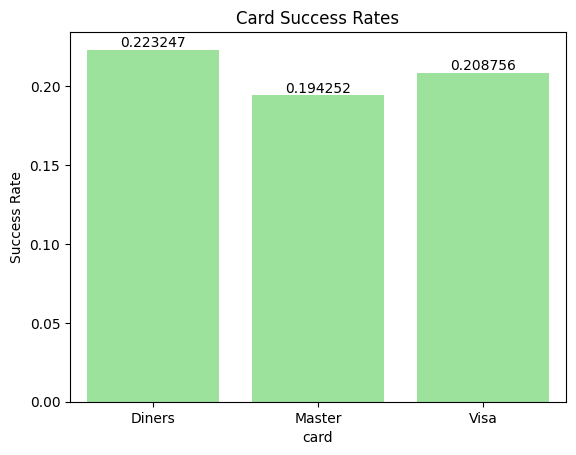

In [ ]:
print("\nCard Success Rates:")
print(card_success_rates,end='\n\t')
# Plotting Card Success Rates
ax = sns.barplot(x=card_success_rates.index, y=card_success_rates['success'], color='lightgreen')
ax.bar_label(ax.containers[0])
plt.title("Card Success Rates")
plt.ylabel("Success Rate")
plt.show()


 Country Success Rates:
              success
country              
Austria      0.204969
Germany      0.201696
Switzerland  0.206025
	

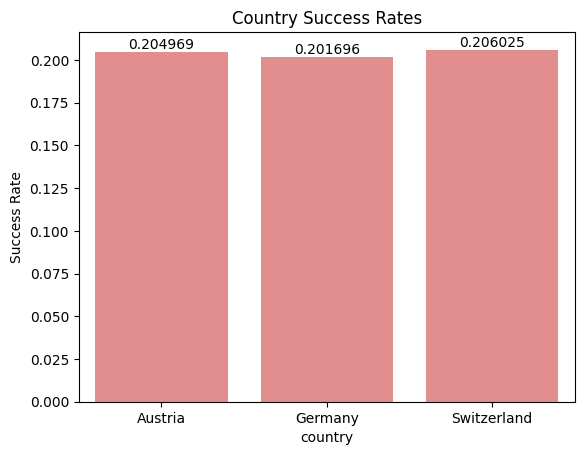

In [ ]:
print("\n Country Success Rates:" )
print(country_success_rates,end='\n\t')

# Plotting Country Success Rates
ax = sns.barplot(x=country_success_rates.index, y=country_success_rates['success'], color='lightcoral')
ax.bar_label(ax.containers[0])
plt.title("Country Success Rates")
plt.ylabel("Success Rate")
plt.show()

Total number of Transactions : 50329
Transaction Status Failed: 40101
Transaction Status success: 10228


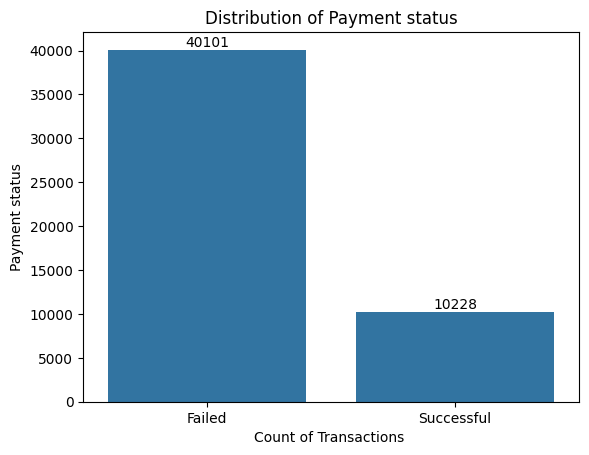

In [ ]:
# Visualize success distribution
print(f"Total number of Transactions : {data['success'].count()}")
print(f"Transaction Status Failed: {data['success'].isin([0]).sum(axis=0)}")
print(f"Transaction Status success: {data['success'].isin([1]).sum(axis=0)}")
ax = sns.countplot(x='success', data=data)
ax.bar_label(ax.containers[0])
plt.title("Distribution of Payment status")
labels = ['Failed', 'Successful']
ax.set_xticklabels(labels)
plt.xlabel("Count of Transactions ")
plt.ylabel("Payment status")
plt.show()

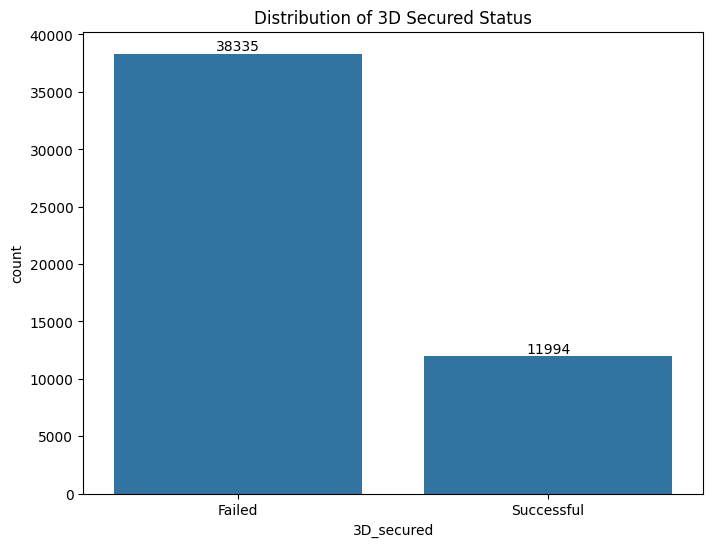

In [ ]:
# Distribution of 3D Secured Status
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='3D_secured', data=data)
ax.bar_label(ax.containers[0])
plt.title("Distribution of 3D Secured Status")
labels = ['Failed', 'Successful']
ax.set_xticklabels(labels)
plt.show()

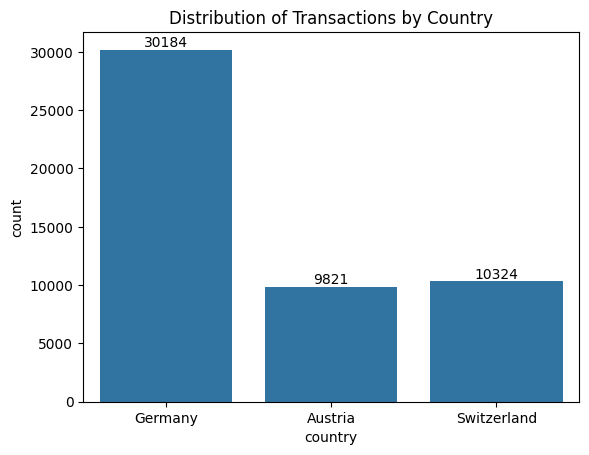

In [ ]:
# Check the distribution of transactions by country
ax=sns.countplot(x='country', data=data)
ax.bar_label(ax.containers[0])
plt.title('Distribution of Transactions by Country')
plt.show()

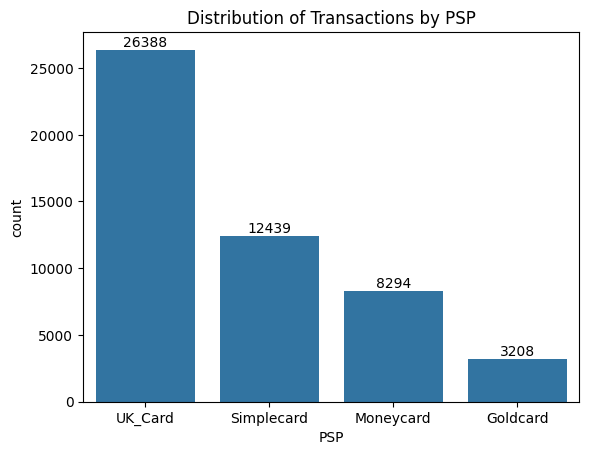

In [ ]:
# Check the distribution of transactions by PSP
ax=sns.countplot(x='PSP', data=data)
ax.bar_label(ax.containers[0])
plt.title('Distribution of Transactions by PSP')
plt.show()

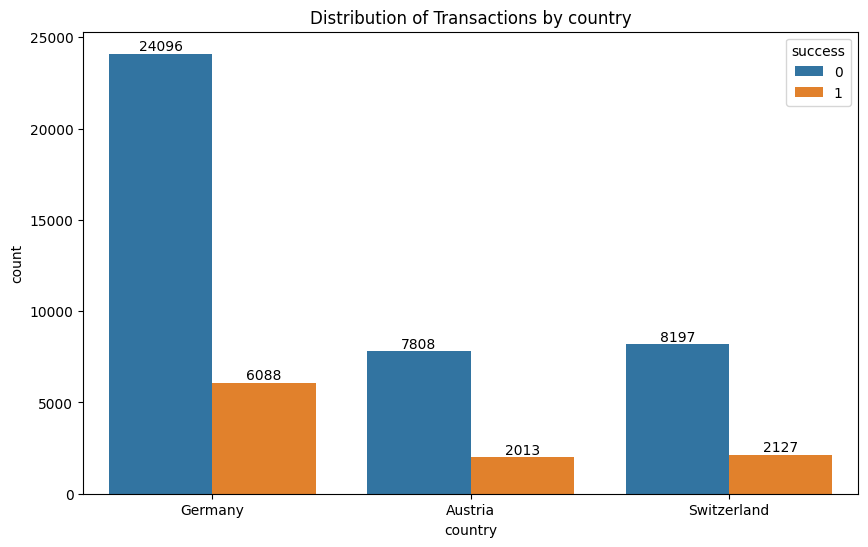

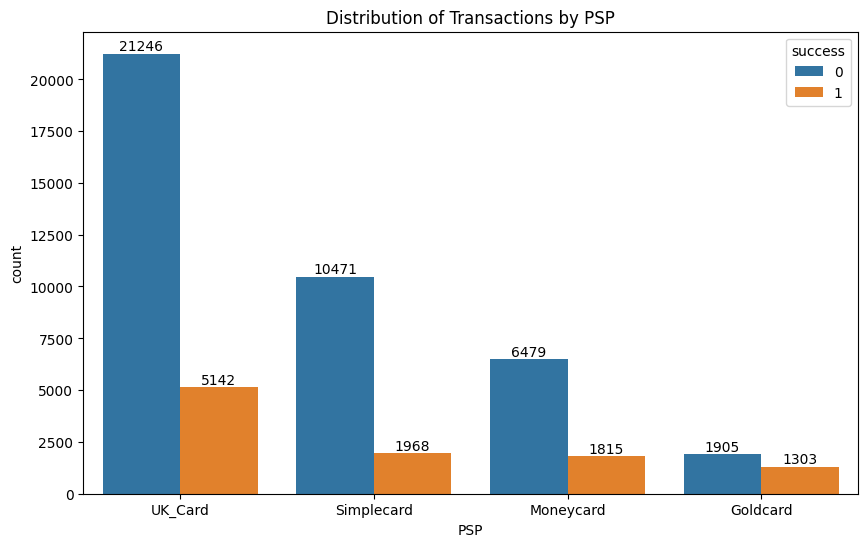

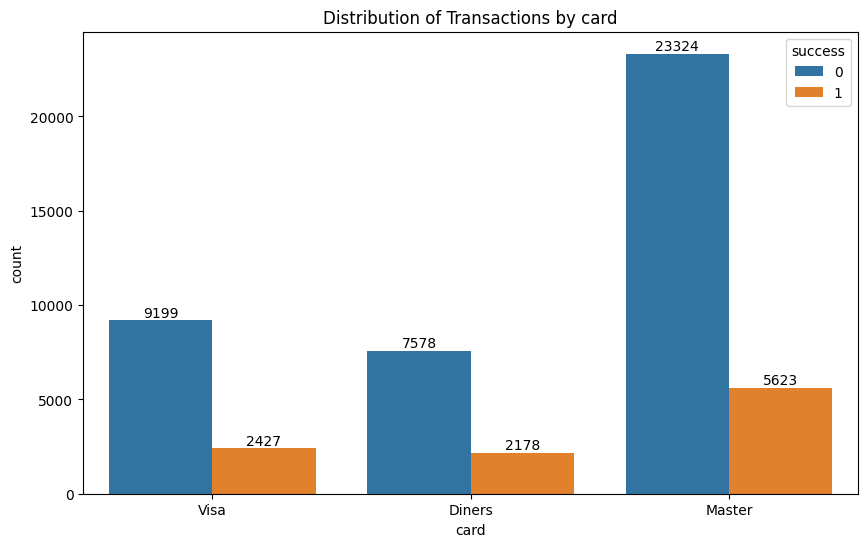

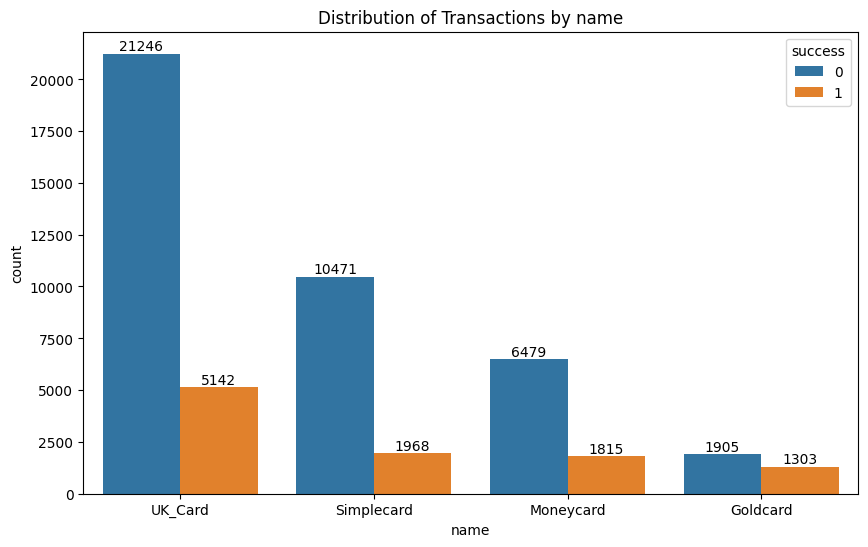

In [ ]:
# Explore the distribution of categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    ax=sns.countplot(x=column, hue='success', data=data)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.title(f'Distribution of Transactions by {column}')
    plt.show()

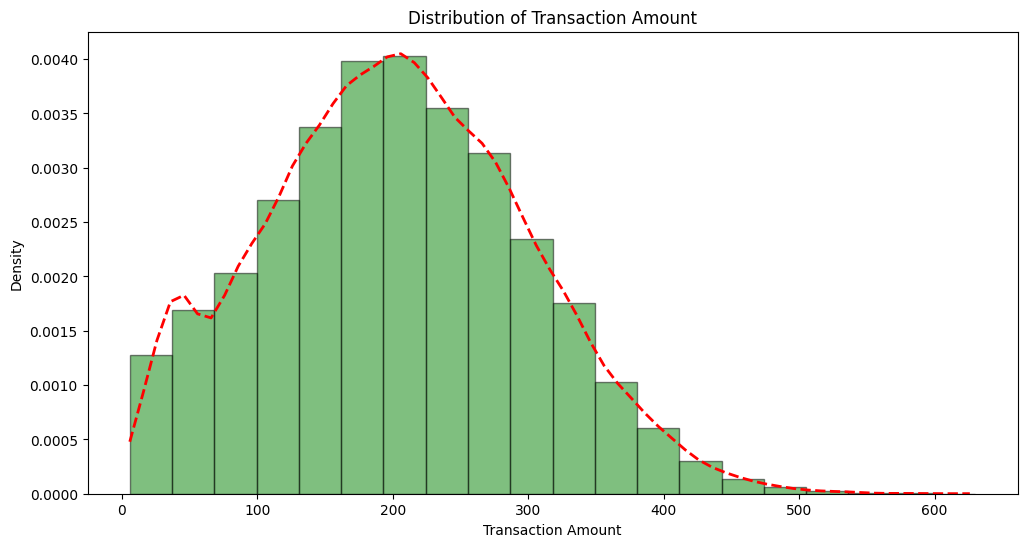

In [ ]:
# Distribution of Amount
plt.figure(figsize=(12, 6))
plt.hist(data['amount'], bins=20, color='green', edgecolor='black', density=True, alpha=0.5)
kde = gaussian_kde(data['amount'])
x_vals = range(int(min(data['amount'])), int(max(data['amount'])), 10)
plt.plot(x_vals, kde(x_vals), color='red', linestyle='dashed', linewidth=2)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.show()

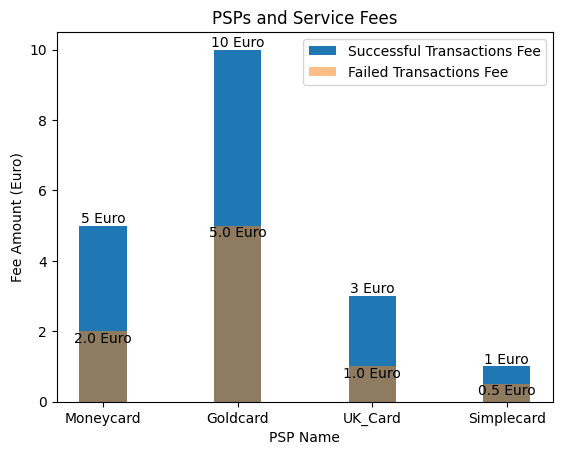

In [ ]:
# List of PSPs and service fees
psp_fees = pd.DataFrame({
    'name': ['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard'],
    'Fee_on_successful_transactions': [5, 10, 3, 1],
    'Fee_on_failed_transactions': [2, 5, 1, 0.5]
})
bar_width = 0.35
index = range(len(psp_fees['name']))
plt.bar(index, psp_fees['Fee_on_successful_transactions'], width=bar_width, label='Successful Transactions Fee')
plt.bar(index, psp_fees['Fee_on_failed_transactions'], width=bar_width, label='Failed Transactions Fee', alpha=0.5)
# Add values on top of the bars
for i, value in enumerate(psp_fees['Fee_on_successful_transactions']):
    plt.text(i, value, f"{value} Euro", ha='center', va='bottom')
for i, value in enumerate(psp_fees['Fee_on_failed_transactions']):
    plt.text(i, value, f"{value} Euro", ha='center', va='top')
plt.title("PSPs and Service Fees")
plt.xlabel("PSP Name")
plt.ylabel("Fee Amount (Euro)")
plt.xticks(index, psp_fees['name'])
plt.legend()
plt.show()

Transactions by PSP:
            Failed Transactions  Successful Transactions
PSP                                                     
Moneycard                  6479                     1815
Goldcard                   1905                     1303
UK_Card                   21246                     5142
Simplecard                10471                     1968


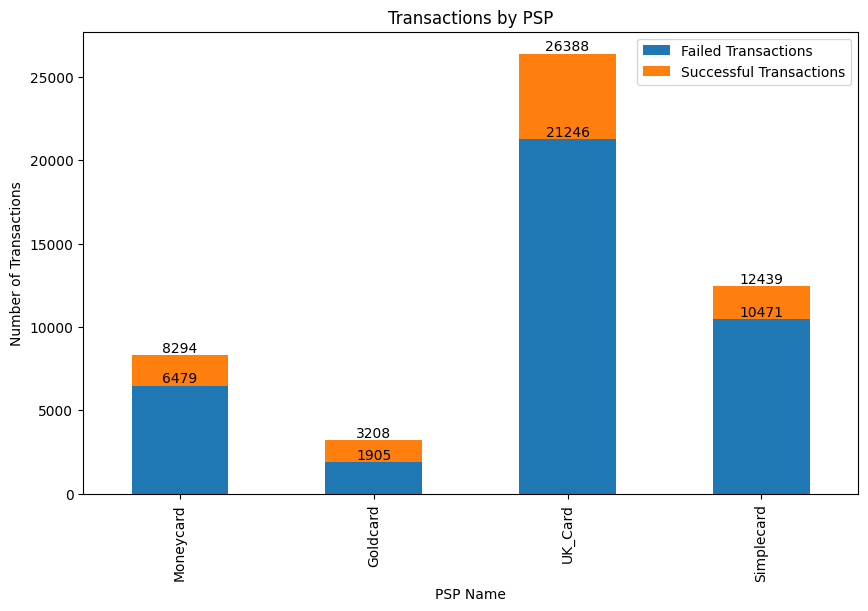

In [ ]:
transactions_by_psp = data.groupby('PSP')['success'].value_counts().unstack(fill_value=0)
transactions_by_psp = transactions_by_psp.loc[psp_fees['name']]
transactions_by_psp.columns = ['Failed Transactions', 'Successful Transactions']
# Display the result
print("Transactions by PSP:")
print(transactions_by_psp)
ax = transactions_by_psp.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title("Transactions by PSP")
plt.xlabel("PSP Name")
plt.ylabel("Number of Transactions")
plt.show()

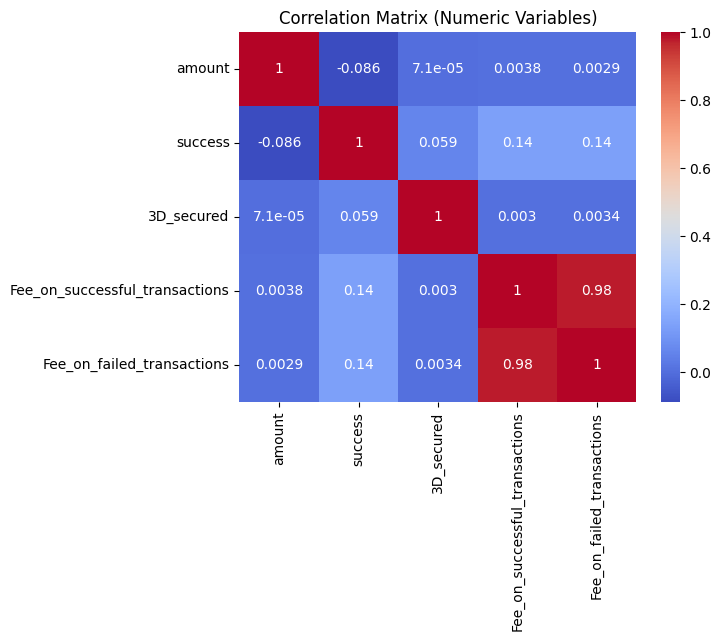

In [ ]:
# Display correlation for numeric columns only
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Variables)')
plt.show()

In [ ]:
# @title Data Preprocessing
le_country = LabelEncoder()
le_card = LabelEncoder()
le_PSP = LabelEncoder()
le_tmsp = LabelEncoder()

data['country'] = le_country.fit_transform(data['country'])
data['card'] = le_card.fit_transform(data['card'])
data['PSP'] = le_PSP.fit_transform(data['PSP'])
data['tmsp'] = le_tmsp.fit_transform(data['tmsp'])
data['total_amount'] = data['amount'] * (1 + data['3D_secured'])
data['country_amount_ratio'] = data['amount'] / data.groupby('country')['amount'].transform('mean')


In [ ]:
# Selecting features and target variable
X = data[['tmsp', 'country', 'amount', 'card', 'PSP', 'total_amount', 'country_amount_ratio']]
y = data['success']

### **Training and evaluating the models**

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# RandomForestClassifier Classifier
baseline_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
y_pred_baseline_train = baseline_model.predict(X_train)


# Additional Metrics
print("Testing set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(f"Precision: {precision_score(y_test, y_pred_baseline, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_baseline, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_baseline)}")
print("\nTraining set Metrics:")
print("Accuracy y_train:", accuracy_score(y_train, y_pred_baseline_train))
print(f"Precision: {precision_score(y_train, y_pred_baseline_train, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_pred_baseline_train, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_pred_baseline_train, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_train, y_pred_baseline_train)}")

Testing set Metrics:
Accuracy: 0.7920723226703755
Precision: 0.7251
Recall: 0.7921
F1 Score: 0.7106

Error Analysis:
Confusion Matrix:
[[7920   64]
 [2029   53]]

Training set Metrics:
Accuracy y_train: 0.8077639520154981
Precision: 0.8230
Recall: 0.8078
F1 Score: 0.7335

Error Analysis:
Confusion Matrix:
[[32058    59]
 [ 7681   465]]


In [ ]:
# LGBM Classifier
advanced_model = LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100,
                                random_state=42,force_row_wise=True)
advanced_model.fit(X_train, y_train)
advanced_predictions = advanced_model.predict(X_test)
advanced_predictions_train = advanced_model.predict(X_train)

# Additional Metrics
print("Testing set Metrics:")
print("Accuracy:", accuracy_score(y_test, advanced_predictions))
print(f"Precision: {precision_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, advanced_predictions, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, advanced_predictions)}")
print("\nTraining set Metrics:")
print("Accuracy y_train:", accuracy_score(y_train, advanced_predictions_train))
print(f"Precision: {precision_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_train, advanced_predictions_train)}")



[LightGBM] [Info] Number of positive: 8146, number of negative: 32117
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202320 -> initscore=-1.371858
[LightGBM] [Info] Start training from score -1.371858
Testing set Metrics:
Accuracy: 0.7933637989270813
Precision: 0.7371
Recall: 0.7934
F1 Score: 0.7118

Error Analysis:
Confusion Matrix:
[[7930   54]
 [2026   56]]

Training set Metrics:
Accuracy y_train: 0.8019521645182922
Precision: 0.7826
Recall: 0.8020
F1 Score: 0.7234

Error Analysis:
Confusion Matrix:
[[31990   127]
 [ 7847   299]]


In [ ]:
# Advanced predictive model GradientBoostingClassifier
advanced_model = GradientBoostingClassifier(random_state=42)
advanced_model.fit(X_train, y_train)
advanced_predictions = advanced_model.predict(X_test)
advanced_predictions_train = advanced_model.predict(X_train)
# Additional Metrics
print("Testing set Metrics:")
print("Accuracy:", accuracy_score(y_test, advanced_predictions))
print(f"Precision: {precision_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, advanced_predictions, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, advanced_predictions)}")
print("\nTraining set Metrics:")
print("Accuracy y_train:", accuracy_score(y_train, advanced_predictions_train))
print(f"Precision: {precision_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_train, advanced_predictions_train)}")


Testing set Metrics:
Accuracy: 0.7927677329624478
Precision: 0.7312
Recall: 0.7928
F1 Score: 0.7109

Error Analysis:
Confusion Matrix:
[[7927   57]
 [2029   53]]

Training set Metrics:
Accuracy y_train: 0.801554777338996
Precision: 0.7775
Recall: 0.8016
F1 Score: 0.7231

Error Analysis:
Confusion Matrix:
[[31975   142]
 [ 7848   298]]


In [ ]:
# Advanced predictive model RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
advanced_model = RandomizedSearchCV(baseline_model, param_distributions, random_state=42, scoring='accuracy', n_jobs=-1,
                                    cv=5, n_iter=20)
advanced_model.fit(X_train, y_train)
advanced_predictions = advanced_model.predict(X_test)
advanced_predictions_X_train = advanced_model.predict(X_train)
# Additional Metrics
print("Testing set Metrics:")
print("Accuracy:", accuracy_score(y_test, advanced_predictions))
print(f"Precision: {precision_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, advanced_predictions, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, advanced_predictions)}")
print("\nTraining set Metrics:")
print("Accuracy y_train:", accuracy_score(y_train, advanced_predictions_train))
print(f"Precision: {precision_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_train, advanced_predictions_train)}")

Testing set Metrics:
Accuracy: 0.7921716669978144
Precision: 0.7253
Recall: 0.7922
F1 Score: 0.7101

Error Analysis:
Confusion Matrix:
[[7924   60]
 [2032   50]]

Training set Metrics:
Accuracy y_train: 0.801554777338996
Precision: 0.7775
Recall: 0.8016
F1 Score: 0.7231

Error Analysis:
Confusion Matrix:
[[31975   142]
 [ 7848   298]]


In [ ]:
# Advanced predictive model
advanced_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
advanced_model.fit(X_train, y_train)
advanced_predictions = advanced_model.predict(X_test)
advanced_predictions_train = advanced_model.predict(X_train)
# Additional Metrics
print("Testing set Metrics:")
print("Accuracy:", accuracy_score(y_test, advanced_predictions))
print(f"Precision: {precision_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, advanced_predictions, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, advanced_predictions)}")
print("\nTraining set Metrics:")
print("Accuracy y_train:", accuracy_score(y_train, advanced_predictions_train))
print(f"Precision: {precision_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_train, advanced_predictions_train)}")

Testing set Metrics:
Accuracy: 0.7920723226703755
Precision: 0.7253
Recall: 0.7921
F1 Score: 0.7107

Error Analysis:
Confusion Matrix:
[[7919   65]
 [2028   54]]

Training set Metrics:
Accuracy y_train: 0.8078136254129101
Precision: 0.8240
Recall: 0.8078
F1 Score: 0.7335

Error Analysis:
Confusion Matrix:
[[32061    56]
 [ 7682   464]]


In [ ]:
# Advanced predictive model XGBClassifier
advanced_model = XGBClassifier(random_state=42)
advanced_model.fit(X_train, y_train)
advanced_predictions = advanced_model.predict(X_test)
advanced_predictions_train = advanced_model.predict(X_train)
# Additional Metrics
print("Testing set Metrics:")
print("Accuracy:", accuracy_score(y_test, advanced_predictions))
print(f"Precision: {precision_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, advanced_predictions, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, advanced_predictions, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, advanced_predictions)}")
print("\nTraining set Metrics:")
print("Accuracy y_train:", accuracy_score(y_train, advanced_predictions_train))
print(f"Precision: {precision_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, advanced_predictions_train, average='weighted'):.4f}")
print("\nError Analysis:")
print(f"Confusion Matrix:\n{confusion_matrix(y_train, advanced_predictions_train)}")


Testing set Metrics:
Accuracy: 0.7850188754222134
Precision: 0.7056
Recall: 0.7850
F1 Score: 0.7139

Error Analysis:
Confusion Matrix:
[[7803  181]
 [1983   99]]

Training set Metrics:
Accuracy y_train: 0.8215483197973326
Precision: 0.8308
Recall: 0.8215
F1 Score: 0.7652

Error Analysis:
Confusion Matrix:
[[31955   162]
 [ 7023  1123]]
